# Austin Shelter Pet Outcomes <a name='top'></a>
*By Stephen FitzSimon*

## Key Takeaways From This Report

## Contents <a name='contents'></a>

*Note: the following hyperlinks will only work on local copies of this notebook; they will not function on GitHub!*

1. <a href='#introduction'>Introduction</a>
    1. <a href='#data_source'>Data Source</a>
2. <a href='#wrangle'>Wrangle The Data</a>
3. <a href='#exploring'>Exploring The Data
    1. <a href='#prop_adopted'>What proportion of animals are getting adopted? </a>
    1. <a href='#animal_type_adopt'>What type of animal is most likely to get adopted? </a>
    
## Introduction <a name='introduction'></a>

<a href='https://www.austintexas.gov/austin-animal-center'>Austin Animal Center</a> provides animal services for the city of Austin, and unincorporated Travis county.  Since 2010 they have implemented a <a href='https://www.austintexas.gov/page/no-kill-plan'>'no-kill' strategy</a> to increase live outcomes for adoptions; this included community partnerships, community education, increased animal services and better data collection.  The goal of this project is to help understand how the Austin Animal Center can provide better services and outcomes for the animals and owners that they serve.  

This report is structered around the data science pipeline of 1. wrangle the data, 2. explore the data and 3. model the data.  Each sections includes key takeaways followed by a discussion that provides more in depth analysis; these are designed to provide all the necessary information to understand the project and arguments.  For more technical and analytical information, visualizations, calculations and code follow these two sections along with annotations and discussions.  If more detail is needed, reference the series of other notebooks as mentioned in the <a href='https://github.com/stephenfitzsimon/pet_adoption_project/blob/main/README.md'>readme file</a>. Hyperlinks are provided throughout to allow the user to navigate to relevant sections.

### Data Source <a name='data_source'></a>
The City of Austin provides an <a href='https://data.austintexas.gov/'>open data website</a> where the data for this project can be found.
- <a href= 'https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Outcomes/9t4d-g238'>Outcome data can be found here</a>
- <a href= 'https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Intakes/wter-evkm'>Intake data can be found here</a>
    
### Intro to the Target Variable
    
The model attempts to predict the outcomes for animals the first time they arrive at the shelter.  In the interest of simplicity, the various categories in the `outcome_type` column are aggregated into four categories. The model attempts to predict one of for outcomes as aggregated from the `outcome_type` column of the data:
1. Adoption
2. Transfer
3. Return to Owner (include Rto-Adopt category)
4. Other (includes the following: euthanised, died, disposal, missing, relocate, lost)

Many of the outcomes in the Other category were due to non-pet status (for example `A860153` is a bat and `A860288` is a grackle, both of which at intake were injured).  Of the euthanised/died animals, most were considered suffering/sick/injured.

<a href='#contents'>Back to Contents</a>

In [84]:
#data science modules used
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#custom modules used
import wrangle
import explore

#global constants
PLT_SIZE = (15,6) #to format the visualizations

## Wrangle The Data <a name='wrangle'></a>

### Key Wrangle Takeaways
- Two tables of data are retrieved from the Austin <a href='https://data.austintexas.gov/'>open data website</a>
- The `Outcome` table contained 141170 records and 12 columns; the `Intake` table contained 141303 records and 12 columns
- Both tables were merged on the key `animal_id`
    - Duplicate records were dropped.  Many of the duplicate records were the same animal.
- Date columns were aggregated into `intake_date` and `outcome_date` and scaled to days
- Repeated columns were removed (example: `color` and `breed` were the same for both intake and outcome tables)
- `name` and `outcome_subtype` had null values inferred
- Remaining nulls were dropped
- Final table is 113944 rows and 17 columns

### Discusion

Data was retrieved from the Austin <a href='https://data.austintexas.gov/'>open data website</a> via the Socrata Open Data API (SODA) and the `sodapy` python module.  The <a href= 'https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Outcomes/9t4d-g238'>outcome data</a> contained 141170 records with 12 columns and the <a href= 'https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Intakes/wter-evkm'>intake data</a> contained 141303 records across 12 rows.  

Each row represents a single animal intake or outcome (a data dictionary can be found <a href='#appedix'>here</a>). The tables were merged on the `animal_id` column; however, duplicates were dropped for this project.  Many of the duplicate rows represented a single animal that had been returned to the shelter after a series of different outcomes--for example, record `A700407` indicates that the animal most likely escaped from the owner and was then returned to the owner multiple times over a period of 6 years (the animal is listed as `Stray` on the `Intake` table, and the the outcome is listed as `Returned to owner` / `Adoption` on the `Outcome` table).  While these records would be ideal to concatenate in a larger project, this project focuses on the adoptability of animals first entering the shelter.  It is most likely the case that the reduplicated records represent an animal that is difficult to adopt.

The date columns did not differ intra-table, and so were aggregated into `intake_date` and `outcome_date` and truncated to year-month-date form.  In addition, columns repeated on both tables were found to contain the same information, and these replicated columns were dropped.  The `outcome_subtype` and `name` columns had a significant number of null values; these were inferred to be `no name` and `no subtype`.  Several columns--`outcome_type`, `sex_at_outcome`, `age_at_outcome` and `sex_at_intake`--had null value; at most these represented 15 rows, and consequently were dropped. The `age_upon_intake` and `age_upon_outcome` both contained ages that were `String` data types of the forms `"x years"`, `"x months"` or `"x days"`. These were converted to a number of days; months were assumed to have $30.5$ days, and years were assumed to have $365.25$ days.  The final calculation was then rounded to `int` datatype.  As these ages are most likely estimation on the part of shelter staff, this is most likely enough accuracy.  Finally, as `date_of_birth` most likely was also an estimation, the column was dropped.

### Code

Code used in this section is contained in `wrangle.py` which programmatically retrieves and prepares the data.  It contains the following functions:
- `get_pet_data` : Checks if a csv file is present, and retrieves data from csv or url. A url query can be forced via `query_url=True`
- `download_data` : Returns the pet outcome and pet intake dataframes from the SODA API
- `make_date_columns` : Aggregates datetime columns into outcome and intake dates
- `null_fill_and_drop` : Fills nulls and drops null values. `name` columns nulls are inferred as no name and `outcome_subtype` is inferred as no subtype.  Remaining nulls are dropped
- `convert_age_column` : Converts age columns to days
- `rename_intake_cols` : Renames the columns from the intake table to make calling them easier
- `rename_intake` : Suffixes the column names of the intake table to distinguish from outcome columns after merge
- `join_tables` : Joins the intake and outake tables on the animal_id column
- `make_target_column` : Maps the various `outcome_types` to the target outcomes
- Flow control functions:
    - `make_pet_dataframe` : Flow control function to retrieve data and prepare it for exploration
    - `get_pet_dataframe` : Flow control function to get dataframe from url or .csv file and join both tables
    - `prepare_pet_dataframe` : Flow control function to prepare data

In [2]:
df = wrangle.make_pet_dataframe()
df.sample(5)

Returning saved csv files.


,animal_id,name,outcome_type,animal_type,sex_upon_outcome,breed,color,outcome_subtype,found_location,intake_type,intake_condition,sex_upon_intake,outcome_date,intake_date,target_outcome,age_at_outcome,age_at_intake
82605,A711580,Tom,Adoption,Cat,Neutered Male,Domestic Shorthair Mix,Brown Tabby,no subtype,14811 Bescott Dr in Austin (TX),Stray,Normal,Intact Male,2015-10-24,2015-09-09,Adoption,61,30
61781,A748107,Diane,Adoption,Dog,Spayed Female,Chihuahua Shorthair Mix,White/Black,Offsite,602 Live Oak Drive in Cedar Park (TX),Stray,Normal,Spayed Female,2017-05-07,2017-04-29,Adoption,3652,3652
19595,A818165,*Moonshine,Transfer,Dog,Intact Male,Pit Bull Mix,Brown Brindle/White,Partner,Austin (TX),Owner Surrender,Sick,Intact Male,2020-06-03,2020-06-03,Transfer,30,30
11423,A834491,*Seymour Skinner,Adoption,Cat,Neutered Male,Domestic Shorthair,Black,no subtype,290 And 973 in Austin (TX),Stray,Normal,Intact Male,2021-06-24,2021-05-14,Adoption,365,365
74709,A727541,*Laramie,Adoption,Dog,Neutered Male,Labrador Retriever,Black/White,no subtype,3636 Rr 620 N in Austin (TX),Stray,Normal,Intact Male,2016-05-28,2016-05-23,Adoption,61,61


<a href='#contents'>Backt to Contents</a>

## Exploring The Data <a name='exploring'></a>

### Key Explore Takeaways
- Overall adoption rate is $0.43$; adoption and transfer represent the majority of outcomes ($0.76$ of all outcomes)
- As the majority of animals in the data are cats or dogs ($0.92$ of the data), the majority of the exploration focuses on these two animal types
    - The adoption rate among cats and dogs is $0.45$
- Most animals are brought in as strays ($0.72$) and are in normal condition ($0.84$)


### Section Contents

1. <a href='#split'>Splitting data into Train, Validate and Test </a>
1. <a href='#prop_outcome'>What are typical animal outcomes?</a>
2. <a href='#intake_condition'>What is the intake condition of adopted animals?</a>

#### How subsections are structured

The following subsections are titled by a question, which is followed by a discussion.  Following, visualization and numeric data are presented; in addition, hypothesis tests are presented if applicable.

### Discussion

The overall adoption rate in the data is $0.43$.  However, the majority of the data ($0.92$) represents cats and dogs which have a higher adoption rate of $0.45$.  This would be expected as, based off of experience, the majority of people who visit a shelter are looking to adopt a cat or a dog.  In addition, $0.67$ of the non cat or dog animals were categorized as wildlife (the majority of which were bats), and are not adoptable.

### Code

The following code is used in this section:
- From the `wrangle.py` module
    - `split_data(df, target_col, cat_cols)` : Gets the proportion of each value in `target_col` for `cat_cols` passed and each subcategory in the cat_cols column.  Essentially performs a `value_counts(normalize=True)` on each category for the `target_col` values

### Splitting data into Train, Validate and Test <a name='split'></a>

Data is split into train, validate and test subsets.  All exploration is done on the train set; validate and test sets are reserved to evaluate machine learning models.

In [3]:
train, validate, test = wrangle.split_data(df) #split the data

In [4]:
train.shape, validate.shape, test.shape #show the size of the subsets

((63808, 17), (27347, 17), (22789, 17))

Take a look at a sample of the train data:

In [5]:
train.sample(5)

,animal_id,name,outcome_type,animal_type,sex_upon_outcome,breed,color,outcome_subtype,found_location,intake_type,intake_condition,sex_upon_intake,outcome_date,intake_date,target_outcome,age_at_outcome,age_at_intake
26634,A806267,no name,Transfer,Cat,Neutered Male,Domestic Shorthair,Orange/White,Partner,4434 Frontier Trl in Austin (TX),Stray,Sick,Neutered Male,2019-10-08,2019-10-08,Transfer,3652,3652
50052,A768233,no name,Euthanasia,Other,Unknown,Bat Mix,Brown,Rabies Risk,1717 W 6Th St in Austin (TX),Wildlife,Normal,Unknown,2018-03-16,2018-03-15,Other,365,365
93465,A696276,*Rubix,Euthanasia,Dog,Intact Male,Pit Bull Mix,Chocolate/White,Aggressive,6513 Hergotz in Austin (TX),Stray,Normal,Intact Male,2015-02-23,2015-02-01,Other,730,730
44384,A777838,no name,Adoption,Cat,Spayed Female,Domestic Shorthair Mix,White/Blue,no subtype,8Th Street And Congress Avenue in Austin (TX),Stray,Normal,Intact Female,2018-08-08,2018-08-04,Adoption,61,30
86459,A708604,Bella,Transfer,Cat,Intact Female,Domestic Shorthair Mix,Black,Partner,9106 N Ih35 in Austin (TX),Public Assist,Normal,Intact Female,2015-07-30,2015-07-29,Transfer,28,28


<a href='#contents'>Back to Contents</a>

### What are typical animal outcomes? <a name='prop_outcome'></a>

#### Key Takeaways
- Adoption ($0.43$) and transfer ($0.33$) are the most common outcomes for all animals
- Cat and dogs are most likely to be adopted or transferred
- Cats and dogs represent $0.98$ of adoptions and $0.96$ of transfers.
- The adoption rate among cats and dogs ($0.45$) is higher than the general adoption rate.

#### What are the most common outcomes overall?

The most common overall outcome for all animals is adoption, followed by transer.  These represent $0.76$ of all outcomes.

Text(0.5, 0, 'Animal Outcome')

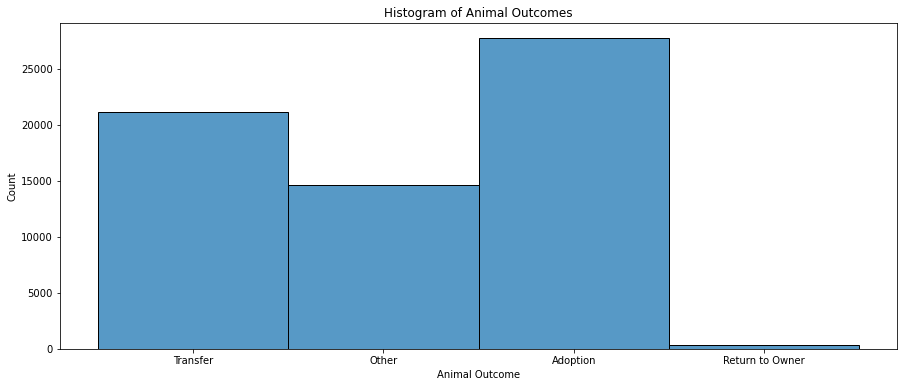

In [26]:
#plot the count of the target outcomes
plt.figure(figsize=PLT_SIZE)
sns.histplot(data=train, x='target_outcome')
#set strings
plt.title('Histogram of Animal Outcomes')
plt.xlabel('Animal Outcome')

In [35]:
# same data but proportional
train.target_outcome.value_counts(normalize=True)

Adoption           0.434710
Transfer           0.331322
Other              0.229297
Return to Owner    0.004670
Name: target_outcome, dtype: float64

#### Are some outcomes determined by animal type?

Cats and dogs represent a large proportion of adopted and transfered animals.  Cats appear more likely to be transfered- I suspect that this is because cat's are likely to be part of the SCRP (Stray Cat Return Program) and the SNR (Spay Neuter Release) program.

Text(0.5, 0, 'Animal Outcome')

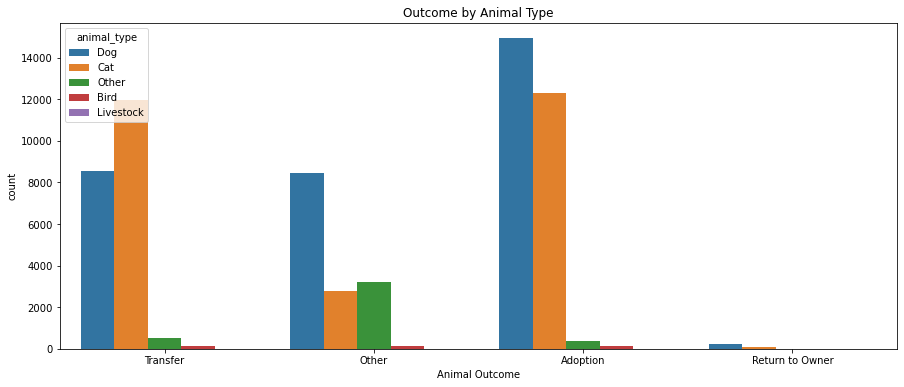

In [33]:
#plot the target outcome hued by animal type
plt.figure(figsize=PLT_SIZE)
sns.countplot(data=train, x='target_outcome', hue='animal_type')
#set strings
plt.title('Outcome by Animal Type')
plt.xlabel('Animal Outcome')

In [34]:
#same data but numeric
train.groupby('animal_type').target_outcome.value_counts(normalize=True)

animal_type  target_outcome 
Bird         Other              0.352632
             Adoption           0.342105
             Transfer           0.305263
Cat          Adoption           0.453473
             Transfer           0.440643
             Other              0.102824
             Return to Owner    0.003060
Dog          Adoption           0.464567
             Transfer           0.265182
             Other              0.263628
             Return to Owner    0.006623
Livestock    Adoption           0.444444
             Transfer           0.333333
             Other              0.222222
Other        Other              0.780464
             Transfer           0.131044
             Adoption           0.088008
             Return to Owner    0.000484
Name: target_outcome, dtype: float64

#### How much of each outcome do cats and dogs represent?

Dogs and cats represent $0.92$ of the data. Unsurprisingly then, they also represent $0.98$ of adoptions and $0.96$ of transfers.

Text(0.5, 0, 'Animal Outcome')

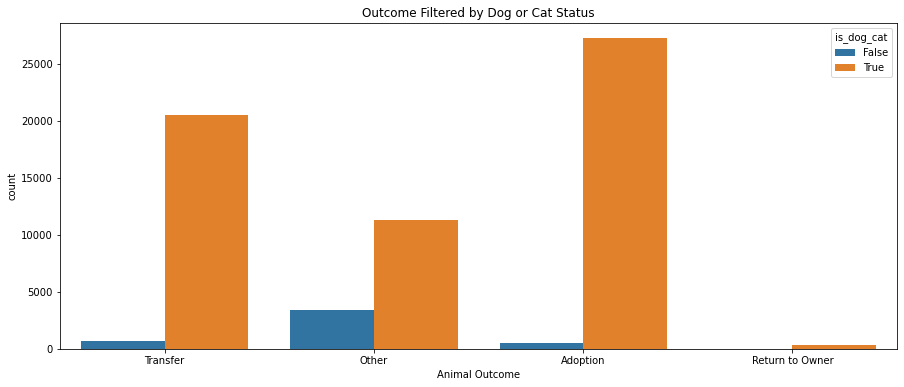

In [41]:
#make a boolean column
train['is_dog_cat'] = train['animal_type'].isin(['Cat', 'Dog'])
#plot the target outcome hued by is_dog_cat
plt.figure(figsize=PLT_SIZE)
sns.countplot(data=train, x='target_outcome', hue='is_dog_cat')
#set strings
plt.title('Outcome Filtered by Dog or Cat Status')
plt.xlabel('Animal Outcome')

In [43]:
#same data but numeric
train.groupby('target_outcome').is_dog_cat.value_counts(normalize=True)

target_outcome   is_dog_cat
Adoption         True          0.982046
                 False         0.017954
Other            True          0.770077
                 False         0.229923
Return to Owner  True          0.993289
                 False         0.006711
Transfer         True          0.968734
                 False         0.031266
Name: is_dog_cat, dtype: float64

In [44]:
#how much of the data is represented by cats and dogs
train.is_dog_cat.mean()

0.9290841273821464

#### What is the rate of adoption among cats and dogs?

Adoption rate among only cats and dogs is $0.46$, and the transfer rate is $0.35$. 

Text(0.5, 0, 'Animal Outcome')

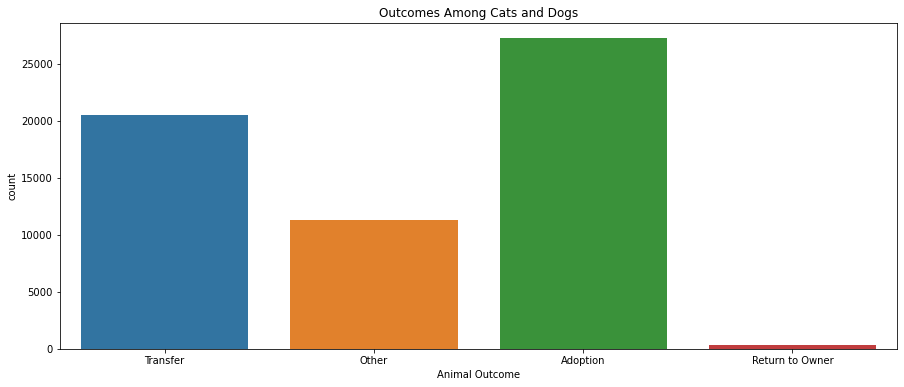

In [50]:
#plot the target outcome hued by is_dog_cat
plt.figure(figsize=PLT_SIZE)
sns.countplot(data=train[train.is_dog_cat], x='target_outcome')
#set strings
plt.title('Outcomes Among Cats and Dogs')
plt.xlabel('Animal Outcome')

In [52]:
#same data but numeric
train[train.is_dog_cat].target_outcome.value_counts(normalize=True)

Adoption           0.459491
Transfer           0.345462
Other              0.190054
Return to Owner    0.004993
Name: target_outcome, dtype: float64

<a href='#contents'>Back to Contents</a>

### What are the animals who get adopted like at intake? <a name='intake_condition'></a>

#### Key Takeaways
- $0.72$ of intake types are strays, that majority of which are cats and dogs
- Most ($0.84$) are in normal condition.

#### What are the intake types of animals in general?

The majority of animals at intake are strays with a proportion of strays at $0.72$, followed by owner surrender.

Text(0.5, 0, 'Intake type')

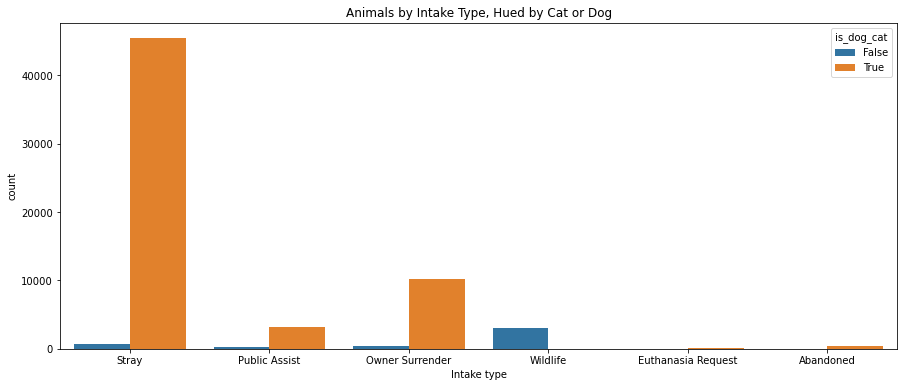

In [57]:
#make plot
plt.figure(figsize=PLT_SIZE)
sns.countplot(data=train, x='intake_type', hue='is_dog_cat')
#set strings
plt.title('Animals by Intake Type, Hued by Cat or Dog')
plt.xlabel('Intake type')

In [58]:
train['intake_type'].value_counts(normalize=True)

Stray                 0.723624
Owner Surrender       0.167173
Public Assist         0.052987
Wildlife              0.047815
Abandoned             0.006394
Euthanasia Request    0.002006
Name: intake_type, dtype: float64

#### What is the intake condition of the animals?

The majority of animals ($0.84$) are in normal condition.

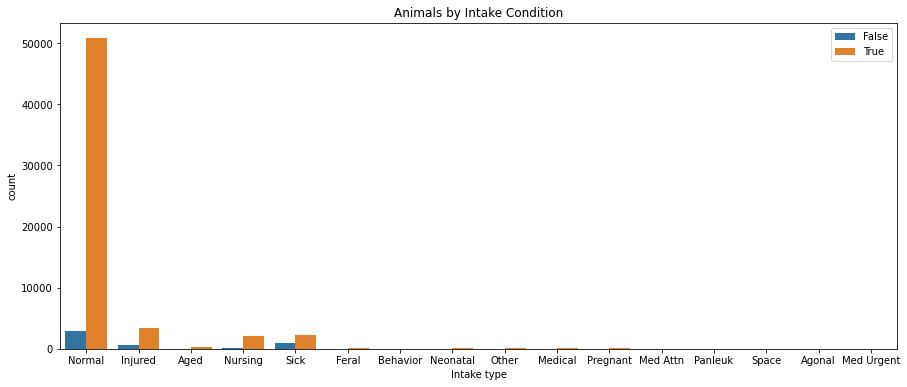

In [61]:
#make plot
plt.figure(figsize=PLT_SIZE)
sns.countplot(data=train, x='intake_condition', hue='is_dog_cat')
#set strings
plt.title('Animals by Intake Condition')
plt.xlabel('Intake type')
plt.legend(loc='upper right')

In [63]:
#same information but numeric
train.intake_condition.value_counts(normalize=True)

Normal        0.842073
Injured       0.062155
Sick          0.050260
Nursing       0.033444
Aged          0.003432
Neonatal      0.003369
Other         0.001959
Medical       0.001081
Feral         0.001034
Pregnant      0.000784
Behavior      0.000298
Space         0.000031
Med Urgent    0.000031
Med Attn      0.000016
Panleuk       0.000016
Agonal        0.000016
Name: intake_condition, dtype: float64


### Are owner surrenders or public assistance intakes more likely to be adopted?

Text(0.5, 0, 'Animal Outcome')

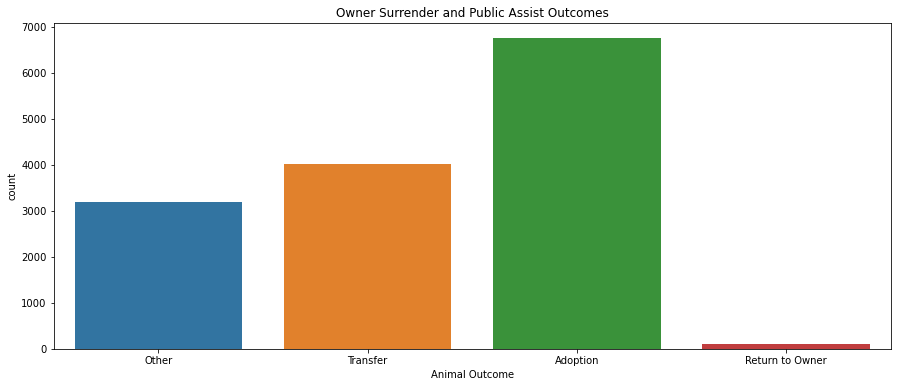

In [67]:
#make plot
plt.figure(figsize=PLT_SIZE)
sns.countplot(data=train[train.intake_type.isin(['Public Assist', 'Owner Surrender'])], x='target_outcome')
#set strings
plt.title('Owner Surrender and Public Assist Outcomes')
plt.xlabel('Animal Outcome')

In [82]:
#same data but numeric
train[train.intake_type.isin(['Owner Surrender'])].target_outcome.value_counts(normalize=True)

Adoption           0.585919
Transfer           0.326427
Other              0.079779
Return to Owner    0.007875
Name: target_outcome, dtype: float64

#### Hypothesis Testing

$H_0$ : Owner surrender is independent of adoption

$H_a$ : Owner Surrender is not independent of adoption